## **Part 1 - Generative Adversarial Network (GAN) for MNIST Digit Generation**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/03.BigDataAnalytics/8.Project3

/content/drive/MyDrive/03.BigDataAnalytics/8.Project3


In [73]:
# training.py

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim = 100


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(-1, z_dim, 1, 1)
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1)
        )

    def forward(self, x):
        return self.model(x)


def gradient_penalty(D, real_images, fake_images):
    batch_size = real_images.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
    interpolated_images = epsilon * real_images + (1 - epsilon) * fake_images
    interpolated_images.requires_grad_(True)

    interpolated_outputs = D(interpolated_images)
    gradients = torch.autograd.grad(
        outputs=interpolated_outputs,
        inputs=interpolated_images,
        grad_outputs=torch.ones_like(interpolated_outputs),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


def train(epochs=300, batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    G = Generator().to(device)
    D = Discriminator().to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizerG = optim.RMSprop(G.parameters(), lr=0.0001)
    optimizerD = optim.RMSprop(D.parameters(), lr=0.00005)

    G.train()
    D.train()

    lambda_gp = 10

    for epoch in range(epochs):
        for i, (real_images, _) in enumerate(train_loader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            real_labels = torch.full((batch_size, 1), 0.8, device=device)
            fake_labels = torch.full((batch_size, 1), 0.0, device=device)

            # Label noise for smoother convergence
            real_labels += 0.05 * torch.rand_like(real_labels)
            fake_labels += 0.05 * torch.rand_like(fake_labels)

            # Train Discriminator
            outputs = D(real_images)
            d_loss_real = criterion(outputs, real_labels)

            z = torch.randn(batch_size, z_dim, 1, 1).to(device)
            fake_images = G(z)
            outputs = D(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)

            gp = gradient_penalty(D, real_images, fake_images.detach())
            d_loss = d_loss_real + d_loss_fake + lambda_gp * gp

            D.zero_grad()
            d_loss.backward()
            optimizerD.step()

            # Train Generator
            z = torch.randn(batch_size, z_dim, 1, 1).to(device)
            fake_images = G(z)
            outputs = D(fake_images)
            g_loss = criterion(outputs, real_labels)

            G.zero_grad()
            g_loss.backward()
            optimizerG.step()

        print(f"Epoch [{epoch+1}/{epochs}]  Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")

        # Save model every 50 epochs
        if (epoch + 1) % 50 == 0:
            torch.save(G.state_dict(), f'./generator_weights_epoch_{epoch+1}.pt')

    # Save final model
    torch.save(G.state_dict(), './generator_weights.pt')
    return G


def plot_generated_images(model, num_images=25):
    model.eval()
    z = torch.randn(num_images, z_dim, 1, 1).to(device)
    generated_images = model(z).detach().cpu()
    generated_images = (generated_images + 1) / 2  # scale to [0, 1]

    n = int(np.sqrt(num_images))
    fig, axes = plt.subplots(n, n, figsize=(5, 5))
    for i in range(n):
        for j in range(n):
            axes[i, j].imshow(generated_images[i * n + j][0], cmap='gray')
            axes[i, j].axis('off')
    plt.show()

In [74]:
def train(start_epoch=300, end_epoch=400, batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    G = Generator().to(device)
    D = Discriminator().to(device)

    if os.path.exists('./generator_weights.pt'):
        G.load_state_dict(torch.load('./generator_weights.pt', map_location=device))
        print(" Loaded existing generator weights.")

    criterion = nn.BCEWithLogitsLoss()
    optimizerG = optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))   # Changed to Adam
    optimizerD = optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))   # Changed to Adam

    G.train()
    D.train()

    lambda_gp = 10
    d_losses = list(np.load('d_losses.npy')) if os.path.exists('d_losses.npy') else []
    g_losses = list(np.load('g_losses.npy')) if os.path.exists('g_losses.npy') else []

    for epoch in range(start_epoch, end_epoch):
        for i, (real_images, _) in enumerate(train_loader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # Train Discriminator
            outputs_real = D(real_images)
            d_loss_real = criterion(outputs_real, real_labels)

            z = torch.randn(batch_size, z_dim, 1, 1).to(device)
            fake_images = G(z)
            outputs_fake = D(fake_images.detach())
            d_loss_fake = criterion(outputs_fake, fake_labels)

            gp = gradient_penalty(D, real_images, fake_images.detach())
            d_loss = d_loss_real + d_loss_fake + lambda_gp * gp

            D.zero_grad()
            d_loss.backward()
            optimizerD.step()

            # Train Generator
            z = torch.randn(batch_size, z_dim, 1, 1).to(device)
            fake_images = G(z)
            outputs = D(fake_images)
            g_loss = criterion(outputs, real_labels)

            G.zero_grad()
            g_loss.backward()
            optimizerG.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        print(f"Epoch [{epoch+1}/{end_epoch}]  Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")

        if (epoch + 1) % 50 == 0:
            torch.save(G.state_dict(), f'./generator_weights_epoch_{epoch+1}.pt')

    torch.save(G.state_dict(), './generator_weights.pt')
    np.save('d_losses.npy', np.array(d_losses))
    np.save('g_losses.npy', np.array(g_losses))

    return G

In [80]:
# Resume training from epoch 300 to 400
G = train(start_epoch=400, end_epoch=600)

✅ Loaded existing generator weights.
Epoch [401/600]  Loss D: 1.4062, Loss G: 0.6715
Epoch [402/600]  Loss D: 1.3863, Loss G: 0.6488
Epoch [403/600]  Loss D: 1.4457, Loss G: 0.7408
Epoch [404/600]  Loss D: 1.4139, Loss G: 0.6929
Epoch [405/600]  Loss D: 1.4042, Loss G: 0.6909
Epoch [406/600]  Loss D: 1.3827, Loss G: 0.7002
Epoch [407/600]  Loss D: 1.3883, Loss G: 0.7060
Epoch [408/600]  Loss D: 1.3641, Loss G: 0.6742
Epoch [409/600]  Loss D: 1.3777, Loss G: 0.7122
Epoch [410/600]  Loss D: 1.3913, Loss G: 0.7639
Epoch [411/600]  Loss D: 1.3278, Loss G: 0.7455
Epoch [412/600]  Loss D: 1.3584, Loss G: 0.7335
Epoch [413/600]  Loss D: 1.3812, Loss G: 0.7519
Epoch [414/600]  Loss D: 1.3972, Loss G: 0.7537
Epoch [415/600]  Loss D: 1.3320, Loss G: 0.7142
Epoch [416/600]  Loss D: 1.4261, Loss G: 0.6815
Epoch [417/600]  Loss D: 1.3344, Loss G: 0.7862
Epoch [418/600]  Loss D: 1.3317, Loss G: 0.7929
Epoch [419/600]  Loss D: 1.3130, Loss G: 0.7385
Epoch [420/600]  Loss D: 1.3100, Loss G: 0.7907
Epo

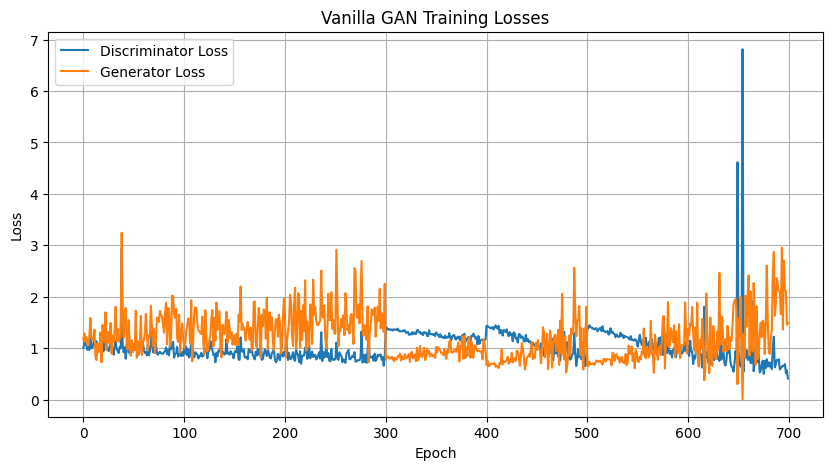

In [81]:
# Plot loss curves after training
import matplotlib.pyplot as plt
import numpy as np

d_losses = np.load('d_losses.npy')
g_losses = np.load('g_losses.npy')

plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Vanilla GAN Training Losses')
plt.legend()
plt.grid(True)
plt.savefig('vanilla_gan_loss_plot.png')
plt.show()

In [82]:
# Load the model architecture
model = Generator().to(device)

# Load the trained weights
model.load_state_dict(torch.load('./generator_weights.pt', map_location=device))

# Save the entire model as 'generator.pt'
torch.save(model, './generator.pt')

print("Full generator model saved as 'generator.pt'")

Full generator model saved as 'generator.pt'


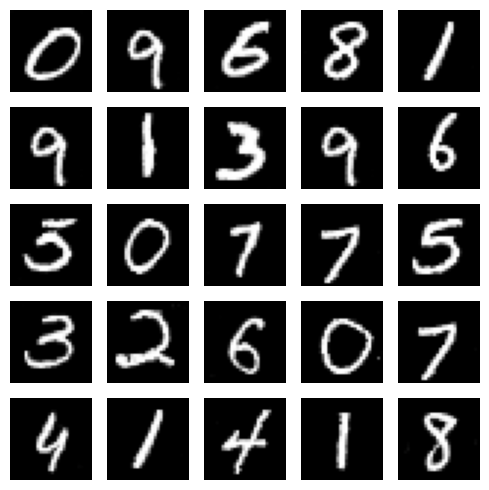

In [18]:
# evaluation.py

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
z_dim = 100  # Added z_dim

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(-1, z_dim, 1, 1)
        return self.model(x)

def load_model():
    model = Generator().to(device)
    model.load_state_dict(torch.load('./generator_weights.pt', map_location=device))
    model.eval()
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            module.eval()
    return model

def generate_images(model, num_images, seed=42):
    torch.manual_seed(seed)  #
    z = torch.randn(num_images, z_dim, 1, 1, device=device)
    with torch.no_grad():
        generated_images = model(z).cpu()
    generated_images = (generated_images + 1) / 2
    return generated_images

def plot_selected_images(images, indices, save_path='selected_grid.png'):
    selected_images = images[indices]
    fig, axes = plt.subplots(5, 5, figsize=(5, 5))
    for i in range(5):
        for j in range(5):
            idx = i * 5 + j
            axes[i, j].imshow(selected_images[idx][0], cmap='gray')
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def plot_all_grid(images, filename="grid_100.png"):
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            idx = i * 10 + j
            axes[i, j].imshow(images[idx][0], cmap='gray')
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

if __name__ == "__main__":
    model = load_model()
    images = generate_images(model, 100, seed=42)

    # Show 100 images in a grid
    #plot_all_grid(images, filename="grid_seed42_100.png")

    # Manually updated selected indices (you should change these after reviewing grid_100.png)
    selected_indices = [24, 65,  0, 93, 4, 3,  87, 77, 18, 29, 11, 7, 84, 94, 10, 44, 49, 19, 66, 67, 77, 90, 58, 79, 56]

    # Final 5x5 output grid
    # plot_selected_images(images, selected_indices)
    #plot_selected_images(images, selected_indices, save_path='600_epochs_grid1.png')

    # Generate an alternate 100 samples using a different seed (to look for digit 6)
    images_100_seed99 = generate_images(model, 100, seed=99)
    #plot_all_grid(images_100_seed99, filename="grid_seed99_100.png")

    selected_indices2 = [60, 50, 25, 91, 6, 50, 22, 5, 50, 72, 34, 19, 14, 52, 28, 88, 2, 27, 31, 52, 41, 6, 49, 1, 62]

    # Final 5x5 output grid
    plot_selected_images(images_100_seed99, selected_indices2, save_path='600_epochs_grid2.png')

## **Part 2 – Conditional GAN (cGAN) for Class-Controlled MNIST Digit Generation**

In [10]:
# training_cgan.py

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim = 100
num_classes = 10  # Digits 0-9
label_dim = 10  # Embedding for 10 classes


class Generator(nn.Module):
    def __init__(self, z_dim, label_dim):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(10, label_dim)  # Embedding for 10 labels
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim + label_dim, 128, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, z, labels):
        label_emb = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)
        label_emb = label_emb.expand(-1, -1, 1, 1)  # Correct shape for concatenation
        z = z.view(-1, z_dim, 1, 1)
        x = torch.cat([z, label_emb], dim=1)  # Concatenate noise and label
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, label_dim):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, 28 * 28)  # Embed to 28x28
        self.model = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),  # Correct input channels: 2 (image + label)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
        )

    def forward(self, img, labels):
        label_emb = self.label_embedding(labels)  # Shape: (batch_size, 28*28)
        label_emb = label_emb.view(-1, 1, 28, 28)  # Reshape to (batch_size, 1, 28, 28)
        x = torch.cat([img, label_emb], dim=1)  # Concatenate along channel axis
        return self.model(x)


def train_cgan(epochs=150, batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    G = Generator(z_dim, label_dim).to(device)
    D = Discriminator(label_dim).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizerG = optim.RMSprop(G.parameters(), lr=0.00005)
    optimizerD = optim.RMSprop(D.parameters(), lr=0.00005)

    G.train()
    D.train()

    for epoch in range(epochs):
        for i, (real_images, labels) in enumerate(train_loader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            labels = labels.to(device)

            real_labels = torch.full((batch_size, 1), 0.8, device=device)
            fake_labels = torch.full((batch_size, 1), 0.0, device=device)

            # --- Train Discriminator ---
            outputs_real = D(real_images, labels)
            d_loss_real = criterion(outputs_real, real_labels)

            z = torch.randn(batch_size, z_dim, 1, 1).to(device)
            random_labels = torch.randint(0, num_classes, (batch_size,), device=device)
            fake_images = G(z, random_labels)
            outputs_fake = D(fake_images.detach(), random_labels)
            d_loss_fake = criterion(outputs_fake, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            D.zero_grad()
            d_loss.backward()
            optimizerD.step()

            # --- Train Generator ---
            z = torch.randn(batch_size, z_dim, 1, 1).to(device)
            random_labels = torch.randint(0, num_classes, (batch_size,), device=device)
            fake_images = G(z, random_labels)
            outputs = D(fake_images, random_labels)
            g_loss = criterion(outputs, real_labels)

            G.zero_grad()
            g_loss.backward()
            optimizerG.step()

        print(f"Epoch [{epoch + 1}/{epochs}]  Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")

        # Save model every 50 epochs
        if (epoch + 1) % 50 == 0:
            torch.save(G.state_dict(), f'./cgan_weights_epoch_{epoch + 1}.pt')

    # Save final model
    torch.save(G.state_dict(), './cgan_weights.pt')
    return G


def plot_generated_images(model, num_images=25, digit=0):
    model.eval()
    z = torch.randn(num_images, z_dim, 1, 1).to(device)
    labels = torch.full((num_images,), digit, device=device)
    generated_images = model(z, labels).detach().cpu()
    generated_images = (generated_images + 1) / 2  # Scale to [0, 1]

    n = int(np.sqrt(num_images))
    fig, axes = plt.subplots(n, n, figsize=(5, 5))
    for i in range(n):
        for j in range(n):
            axes[i, j].imshow(generated_images[i * n + j][0], cmap='gray')
            axes[i, j].axis('off')
    plt.show()

Epoch [1/150]  Loss D: 1.3242, Loss G: 0.9769
Epoch [2/150]  Loss D: 1.0782, Loss G: 1.0465
Epoch [3/150]  Loss D: 1.0805, Loss G: 0.9147
Epoch [4/150]  Loss D: 1.1162, Loss G: 0.9277
Epoch [5/150]  Loss D: 1.0754, Loss G: 1.0765
Epoch [6/150]  Loss D: 1.3225, Loss G: 0.7134
Epoch [7/150]  Loss D: 1.0739, Loss G: 1.2411
Epoch [8/150]  Loss D: 1.0959, Loss G: 0.9136
Epoch [9/150]  Loss D: 1.2800, Loss G: 1.2479
Epoch [10/150]  Loss D: 1.3259, Loss G: 0.7831
Epoch [11/150]  Loss D: 0.8535, Loss G: 0.8336
Epoch [12/150]  Loss D: 1.2758, Loss G: 0.9291
Epoch [13/150]  Loss D: 1.4087, Loss G: 1.3580
Epoch [14/150]  Loss D: 1.3605, Loss G: 1.1579
Epoch [15/150]  Loss D: 1.6210, Loss G: 0.8409
Epoch [16/150]  Loss D: 1.1972, Loss G: 0.7185
Epoch [17/150]  Loss D: 1.0412, Loss G: 0.9199
Epoch [18/150]  Loss D: 1.5947, Loss G: 1.0866
Epoch [19/150]  Loss D: 1.0954, Loss G: 1.0274
Epoch [20/150]  Loss D: 1.2266, Loss G: 1.1439
Epoch [21/150]  Loss D: 1.1558, Loss G: 0.9397
Epoch [22/150]  Loss D

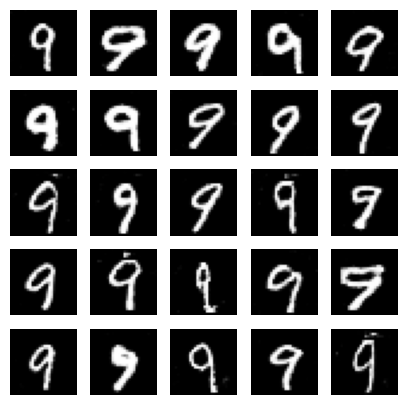

In [11]:
def train_cgan(epochs=150, batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    G = Generator(z_dim, label_dim).to(device)
    D = Discriminator(label_dim).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizerG = optim.RMSprop(G.parameters(), lr=0.00005)
    optimizerD = optim.RMSprop(D.parameters(), lr=0.00005)

    G.train()
    D.train()

    for epoch in range(epochs):
        for i, (real_images, labels) in enumerate(train_loader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            labels = labels.to(device)

            real_labels = torch.full((batch_size, 1), 0.8, device=device)
            fake_labels = torch.full((batch_size, 1), 0.0, device=device)

            # --- Train Discriminator ---
            outputs_real = D(real_images, labels)
            d_loss_real = criterion(outputs_real, real_labels)

            z = torch.randn(batch_size, z_dim, 1, 1).to(device)
            random_labels = torch.randint(0, num_classes, (batch_size,), device=device)
            fake_images = G(z, random_labels)
            outputs_fake = D(fake_images.detach(), random_labels)
            d_loss_fake = criterion(outputs_fake, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            D.zero_grad()
            d_loss.backward()
            optimizerD.step()

            # --- Train Generator ---
            z = torch.randn(batch_size, z_dim, 1, 1).to(device)
            random_labels = torch.randint(0, num_classes, (batch_size,), device=device)
            fake_images = G(z, random_labels)
            outputs = D(fake_images, random_labels)
            g_loss = criterion(outputs, real_labels)

            G.zero_grad()
            g_loss.backward()
            optimizerG.step()

        print(f"Epoch [{epoch + 1}/{epochs}]  Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")

        # Save model every 50 epochs
        if (epoch + 1) % 50 == 0:
            torch.save(G.state_dict(), f'./cgan_weights_epoch_{epoch + 1}.pt')

    # Save final model
    torch.save(G.state_dict(), './cgan_weights.pt')
    return G


def plot_generated_images(model, num_images=25, digit=0):
    model.eval()
    z = torch.randn(num_images, z_dim, 1, 1).to(device)
    labels = torch.full((num_images,), digit, device=device)
    generated_images = model(z, labels).detach().cpu()
    generated_images = (generated_images + 1) / 2  # Scale to [0, 1]

    n = int(np.sqrt(num_images))
    fig, axes = plt.subplots(n, n, figsize=(5, 5))
    for i in range(n):
        for j in range(n):
            axes[i, j].imshow(generated_images[i * n + j][0], cmap='gray')
            axes[i, j].axis('off')
    plt.show()

# Train the cGAN
G_cgan = train_cgan(epochs=150, batch_size=64)

# Plot sample images for digit 9 after training
plot_generated_images(G_cgan, num_images=25, digit=9)

In [15]:
z_dim = 100
label_dim = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate the Generator architecture
G_cgan = Generator(z_dim, label_dim).to(device)

# Load weights
G_cgan.load_state_dict(torch.load('./cgan_weights.pt', map_location=device))

# Save full model
torch.save(G_cgan, './cgan_generator.pt')
print("Full cGAN model saved as 'cgan_generator.pt'")

Full cGAN model saved as 'cgan_generator.pt'


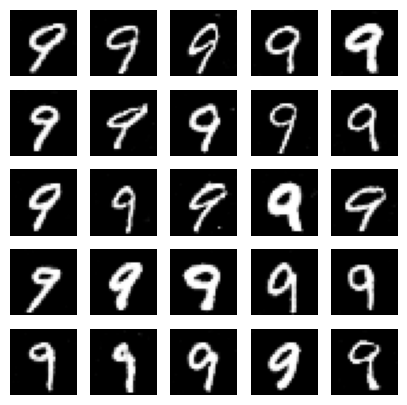

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# Define the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Generator(nn.Module):
    def __init__(self, z_dim, label_dim):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(10, label_dim)  # Embedding for 10 labels
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim + label_dim, 128, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, z, labels):
        label_emb = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)
        label_emb = label_emb.expand(-1, -1, 1, 1)  # Correct shape for concatenation
        z = z.view(-1, z_dim, 1, 1)
        x = torch.cat([z, label_emb], dim=1)  # Concatenate noise and label
        return self.model(x)

def load_model():
    '''
    Load the trained cGAN generator model and set to eval mode.
    '''
    # Corrected Generator instantiation with required arguments
    model = Generator(z_dim=100, label_dim=10).to(device)
    model.load_state_dict(torch.load('./cgan_weights.pt', map_location=device))
    model.eval()
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            module.eval()
    return model


def generate_images(model, num_images, digit):
    '''
    Generate images of a specific digit using the trained model.
    '''
    z_dim = 100
    z = torch.randn(num_images, z_dim, 1, 1, device=device)  # Latent space noise
    labels = torch.full((num_images,), digit, device=device)  # Labels for digit
    with torch.no_grad():
        generated_images = model(z, labels).cpu()
    generated_images = (generated_images + 1) / 2  # Scale from [-1, 1] to [0, 1]
    return generated_images


def plot_images(generated_images, grid_size):
    '''
    Plot generated images in a grid.
    '''
    n = grid_size
    fig, axes = plt.subplots(n, n, figsize=(5, 5))
    for i in range(n):
        for j in range(n):
            image = generated_images[i * n + j].squeeze().numpy()
            axes[i, j].imshow(image, cmap='gray')
            axes[i, j].axis('off')

    # Save the generated image to a file
    plt.savefig('cgan_generated_images.png')
    plt.show()


if __name__ == "__main__":
    # Load the cGAN generator model
    model = load_model()

    # Generate images of digit 9 (or any other digit from 0 to 9)
    num_images = 25
    digit = 9  # Change to any digit between 0-9 to generate that digit
    images = generate_images(model, num_images, digit)

    # Plot the generated images
    grid_size = 5
    plot_images(images, grid_size)

    # Visualize using IPython display
    from IPython.display import Image
    Image(filename='/content/drive/MyDrive/03.BigDataAnalytics/8.Project3/cgan_generated_images.png')